In [ ]:
import praw

In [22]:
from dotenv import load_dotenv
import os

load_dotenv()

CLIENT_ID = os.getenv("R_CLIENT_ID")
CLIENT_SECRET = os.getenv("R_CLIENT_SECRET")
USER_AGENT = os.getenv("R_USER_AGENT")
USERNAME = os.getenv("R_USERNAME")
PASSWORD = os.getenv("R_PASSWORD")

In [23]:
reddit_instance = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT,
    username=USERNAME,
    password=PASSWORD
)

In [24]:
subreddit = reddit_instance.subreddit('portugal2')
subreddit

Subreddit(display_name='portugal2')

In [25]:
import pandas as pd
from datetime import datetime

top_posts = subreddit.top(limit=1000, time_filter="year")

posts_df = []
for post in top_posts:
    # Converte o timestamp Unix para um formato de data legível
    post_date = datetime.utcfromtimestamp(post.created_utc).strftime('%d-%m-%Y')

    # Adiciona os dados do post à lista
    posts_df.append({
        'Title': post.title,
        'Content': post.selftext,
        'Number of Comments': post.num_comments,
        'Created': post_date  # Data de criação
    })
posts_df = pd.DataFrame(posts_df)
posts_df.to_excel('reddit.xlsx', index=False)

#### Eliminar as linhas em branco

In [33]:
# Carregar o arquivo Excel 
dataset_path = 'reddit.xlsx'
posts_df = pd.read_excel(dataset_path)

# Remover linhas onde a coluna "Content" está vazia
posts_df = posts_df[posts_df['Content'].str.strip() != ""]
posts_df = posts_df[posts_df['Content'].notna()]

# Salvar o dataset limpo em um novo arquivo Excel
cleaned_dataset_path = 'reddit_cleaned.xlsx'
posts_df.to_excel(cleaned_dataset_path, index=False)

#### Pré-processamento de Texto (VER)

In [39]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Certifique-se de baixar os recursos necessários do NLTK antes de executar
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Carregar as stopwords em português
stop_words = set(stopwords.words('portuguese'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Converter para minúsculas
    text = text.lower()
    
    # Remover caracteres especiais, mantendo apenas letras e números
    text = re.sub(r'[^a-zá-úãõàâäçéêíóôúùñ\s]', '', text)
    
    # Remover números 
    text = re.sub(r'\d+', '', text)
    
    # Tokenizar as palavras
    words = word_tokenize(text)
    
    # Remover stopwords
    words_filtered = [word for word in words if word not in stop_words]
    
    # Lematizar as palavras
    words_lemmatized = [lemmatizer.lemmatize(word) for word in words_filtered]
    
    # Juntar as palavras lematizadas de volta em uma string
    return ' '.join(words_lemmatized)

# Aplicar o pré-processamento ao conteúdo
posts_df['Content'] = posts_df['Content'].apply(lambda x: clean_text(str(x)))

# Salvar o DataFrame processado em um arquivo Excel
posts_df.to_excel('reddit_cleaned_processed.xlsx', index=False)

# Exibir as primeiras linhas do DataFrame processado
print(posts_df.head())

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/beatrizdias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/beatrizdias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/beatrizdias/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                Title  \
1                              Vamos limpar Portugal!   
2                  Táxi falso no aeroporto de Lisboa    
6   Bloqueiam a estrada para pedir dinheiro e furt...   
7                  Para quem ainda não compreendeu...   
10                     A Maria João está desaparecida   

                                              Content  Number of Comments  \
1   nata pessoas vão tornar possivel cristina rodr...                 610   
2                         un turistas serem enganados                 137   
6   faro bloqueiam estrada modo obrigar carros par...                 147   
7       agora vejam lá querem surpresas daqui doi ano                 132   
10  maria joão ano fugiu casa namorado ano dia ant...                 319   

       Created  
1   14-03-2024  
2   10-07-2024  
6   28-07-2024  
7   27-03-2024  
10  10-04-2024  


#### O teu código inicial

In [6]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('portuguese'))
# Função para remover stopwords, números e deixar tudo em minúsculas
def clean_text(text):
    # Converter o texto para minúsculas
    text = text.lower()
    
    # Remover números
    text = re.sub(r'\d+', '', text)
    
    # Tokenizar o texto em palavras
    words = word_tokenize(text)
    
    # Remover stopwords
    words_filtered = [word for word in words if word not in stop_words]
    
    # Juntar as palavras filtradas em uma string
    return ' '.join(words_filtered)

# Aplicar a função ao dataframe
posts_df['Content'] = posts_df['Content'].apply(lambda x: clean_text(str(x)))

# Salvar o DataFrame processado em um arquivo Excel
posts_df.to_excel('reddit_cleaned.xlsx', index=False)

#### Análise Exploratória dos Dados

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/beatrizdias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/var/folders/26/7s9y6vdj3xs20whynm5xn0500000gn/T/ipykernel_52620/4046691527.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette="viridis")


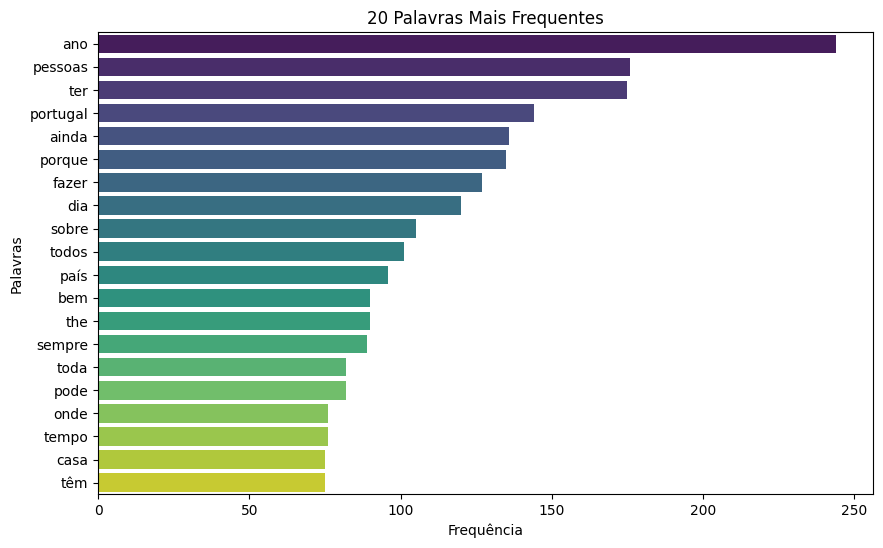

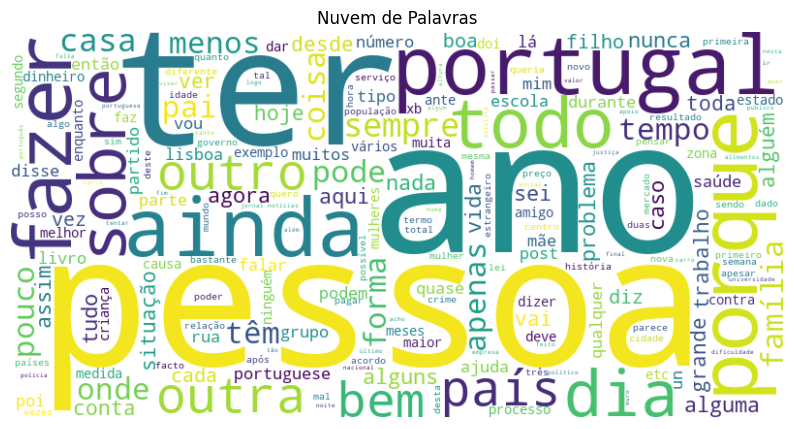

Top 10 Bigramas:
jornal notícias: 27
toda gente: 22
xb jornal: 19
cada vez: 18
muitas vezes: 17
milhões euro: 17
reino unido: 16
mil euro: 15
redes sociais: 14
cinco ano: 12

Top 10 Trigramas:
xb jornal notícias: 17
jornal notícias março: 8
mil milhões euro: 8
gonçalo nascimento rodrigues: 7
agência portuguesa ambiente: 5
jornal notícias janeiro: 5
crédito habitação concedido: 5
jornal notícias maio: 4
out of the: 4
expresidente agência portuguesa: 4


/var/folders/26/7s9y6vdj3xs20whynm5xn0500000gn/T/ipykernel_52620/4046691527.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bigram_counts, y=bigram_words, palette="coolwarm")


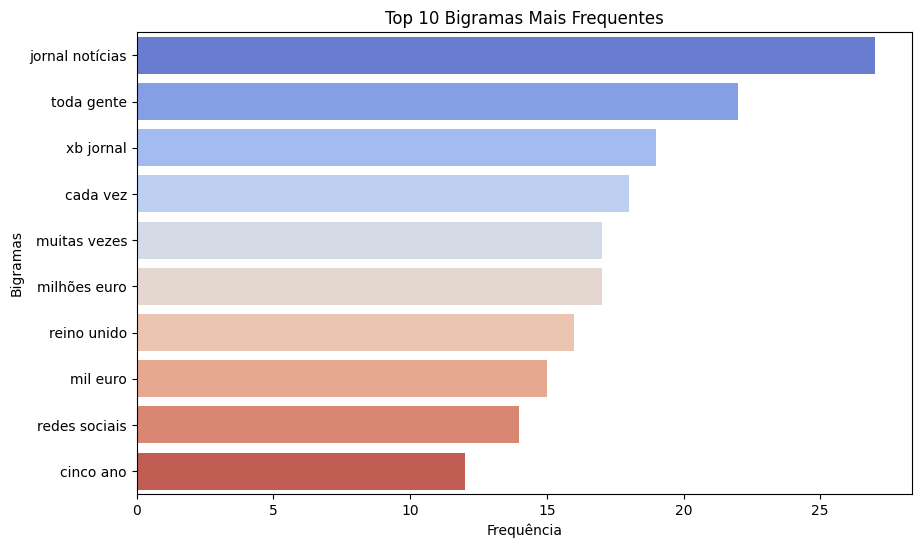

/var/folders/26/7s9y6vdj3xs20whynm5xn0500000gn/T/ipykernel_52620/4046691527.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=trigram_counts, y=trigram_words, palette="coolwarm")


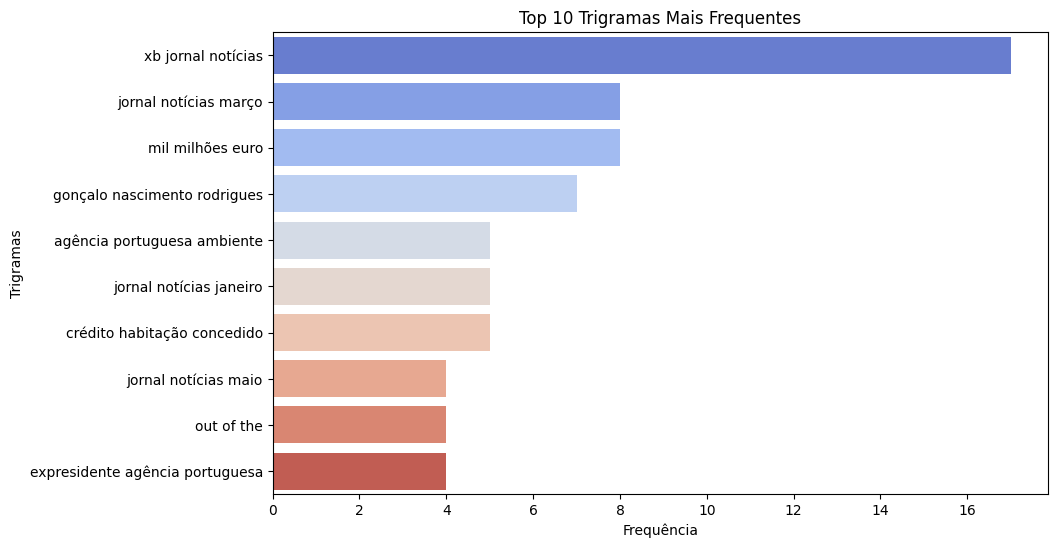

In [43]:
import matplotlib.pyplot as plt
from collections import Counter
from nltk.util import ngrams
from wordcloud import WordCloud
import seaborn as sns
from nltk.tokenize import word_tokenize
import nltk

# Certifique-se de baixar os recursos necessários do NLTK
nltk.download('punkt')

# Carregar o dataset processado
dataset_path = 'reddit_cleaned_processed.xlsx'
df = pd.read_excel(dataset_path)

# Unir todos os textos da coluna 'Content' em uma única string
all_text = " ".join(df['Content'].dropna())

# Tokenização: separar todas as palavras
tokens = word_tokenize(all_text)

# Contar a frequência das palavras
word_freq = Counter(tokens)

# Plotar os 20 termos mais frequentes
most_common_words = word_freq.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(10, 6))
sns.barplot(x=counts, y=words, palette="viridis")
plt.title("20 Palavras Mais Frequentes")
plt.xlabel("Frequência")
plt.ylabel("Palavras")
plt.show()

# Gerar nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuvem de Palavras")
plt.show()

# Análise de n-grams (bigramas e trigramas)
def analyze_ngrams(tokens, n):
    ngram_counts = Counter(ngrams(tokens, n))
    return ngram_counts.most_common(10)

# Bigramas
bigrams = analyze_ngrams(tokens, 2)
print("Top 10 Bigramas:")
for bigram, freq in bigrams:
    print(f"{' '.join(bigram)}: {freq}")

# Trigramas
trigrams = analyze_ngrams(tokens, 3)
print("\nTop 10 Trigramas:")
for trigram, freq in trigrams:
    print(f"{' '.join(trigram)}: {freq}")

# Visualizar os bigramas em um gráfico
bigram_words = [' '.join(bigram) for bigram, freq in bigrams]
bigram_counts = [freq for bigram, freq in bigrams]

plt.figure(figsize=(10, 6))
sns.barplot(x=bigram_counts, y=bigram_words, palette="coolwarm")
plt.title("Top 10 Bigramas Mais Frequentes")
plt.xlabel("Frequência")
plt.ylabel("Bigramas")
plt.show()

# Visualizar os trigramas em um gráfico
trigram_words = [' '.join(trigram) for trigram, freq in trigrams]
trigram_counts = [freq for trigram, freq in trigrams]

plt.figure(figsize=(10, 6))
sns.barplot(x=trigram_counts, y=trigram_words, palette="coolwarm")
plt.title("Top 10 Trigramas Mais Frequentes")
plt.xlabel("Frequência")
plt.ylabel("Trigramas")
plt.show()

#### Analise de Sentimentos 

In [40]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Carrega o modelo e o tokenizer RoBERTa
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

# Função para analisar o sentimento do texto com tokenização manual
def analyze_sentiment(text):
    if isinstance(text, str) and pd.notnull(text):
        # Tokeniza o texto
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        
        # Passa pelo modelo
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Obtém as probabilidades e determina o rótulo de sentimento
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        sentiment_label = torch.argmax(probs).item()
        
        # Mapeia os índices para os rótulos de sentimento: 0=Negative, 1=Neutral, 2=Positive
        labels = ['Negative', 'Neutral', 'Positive']
        return labels[sentiment_label]
    else:
        return "No analysis"

# Carregar o dataset limpo
dataset_path = 'reddit_cleaned_processed.xlsx'  # Arquivo limpo gerado anteriormente
df = pd.read_excel(dataset_path)

# Aplica a função de análise de sentimento ao conteúdo do post e cria uma nova coluna 'sentiment'
df['Sentiment'] = df['Content'].apply(analyze_sentiment)

# Salva o DataFrame com a nova coluna de sentimento em um novo arquivo Excel
output_path = 'reddit_top_posts_with_sentiment.xlsx'
df.to_excel(output_path, index=False)

# Contar os valores únicos na coluna 'Sentiment'
sentiment_counts = df['Sentiment'].value_counts()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
